![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Deep Learning Methods </center>
## <center> Lecture 16 - GAN </center>
### <center> Adversarial Attacks </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/DeepLearningMethods/16_GAN/MainAdversarialAttack.ipynb)

In [1]:
#-- Wide screen :
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
#-- Auto reload:
%load_ext autoreload
%autoreload 2

For Colab users:

In [3]:
if 'google.colab' in str(get_ipython()):
    !pip install torchinfo
    !npx degit FixelAlgorithmsTeam/FixelCourses/DeepLearningMethods/16_GAN/DeepLearningFramework ./DeepLearningFramework

In [4]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

import torch
import torch.nn               as nn
import torch.nn.functional    as F
import torch.optim            as optim
import torchvision.transforms as transforms
import torchinfo

torch.backends.cudnn.benchmark = True

#### Load MNIST data:

In [5]:
import torchvision.transforms as transforms
import torchvision

dataPath   = r'../../data/'
oTransform = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.5], [0.5])])

oTrainSet  = torchvision.datasets.MNIST(root=dataPath, train=True,  transform=oTransform, download=True)
oTestSet   = torchvision.datasets.MNIST(root=dataPath, train=False, transform=oTransform, download=True)

In [6]:
batchSize = 256
oTrainDL  = torch.utils.data.DataLoader(oTrainSet, shuffle=True,  batch_size=1*batchSize, num_workers=2, persistent_workers=True)
oTestDL   = torch.utils.data.DataLoader(oTestSet,  shuffle=False, batch_size=2*batchSize, num_workers=2, persistent_workers=True)

mX,       vY = next(iter(oTrainDL))
mX.shape, vY.shape

(torch.Size([256, 1, 28, 28]), torch.Size([256]))

#### Classifier model:

In [7]:
class ResBlock(nn.Module):
    def __init__(self, C):
        super().__init__()
        self.oBlock = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(C, C,   3, padding=1, stride=1), nn.BatchNorm2d(1*C), nn.LeakyReLU(0.2),
            nn.Conv2d(C, 2*C, 3, padding=1, stride=2), nn.BatchNorm2d(2*C), nn.LeakyReLU(0.2),
        )
        
    def forward(self, mX):
        mOut  = self.oBlock(mX)
        mX    = F.interpolate(mX, scale_factor=[1/2, 1/2])
        mOut += mX.repeat(1,2,1,1)
    
        return mOut

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.oDis = nn.Sequential(
            nn.Identity(),
            nn.Conv2d(1,   16, kernel_size=3, padding=3), nn.LeakyReLU(), 
            ResBlock (16),
            ResBlock (32),
            ResBlock (64),
            nn.Conv2d(128, 10, kernel_size=4),                                            
            nn.Flatten()
        )
        
    def forward(self, mX):
        vScore = self.oDis(mX)
    
        return vScore
#=============================================================#
#=============================================================#
print(torchinfo.summary(Model(), mX.shape))

vScore = Model()(mX)
vScore.shape

Layer (type:depth-idx)                   Output Shape              Param #
Model                                    --                        --
├─Sequential: 1-1                        [256, 10]                 --
│    └─Identity: 2-1                     [256, 1, 28, 28]          --
│    └─Conv2d: 2-2                       [256, 16, 32, 32]         160
│    └─LeakyReLU: 2-3                    [256, 16, 32, 32]         --
│    └─ResBlock: 2-4                     [256, 32, 16, 16]         --
│    │    └─Sequential: 3-1              [256, 32, 16, 16]         7,056
│    └─ResBlock: 2-5                     [256, 64, 8, 8]           --
│    │    └─Sequential: 3-2              [256, 64, 8, 8]           27,936
│    └─ResBlock: 2-6                     [256, 128, 4, 4]          --
│    │    └─Sequential: 3-3              [256, 128, 4, 4]          111,168
│    └─Conv2d: 2-7                       [256, 10, 1, 1]           20,490
│    └─Flatten: 2-8                      [256, 10]                 -

C:\Users\oryai\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


torch.Size([256, 10])

In [9]:
from torch.optim.lr_scheduler       import OneCycleLR
from DeepLearningFramework.Training import TrainModel
from DeepLearningFramework.Metric   import Accuracy

DEVICE = torch.device       ('cuda:0' if torch.cuda.is_available() else 'cpu')
Loss   = nn.CrossEntropyLoss()
Metric = Accuracy           ()

#### Train the model:

In [10]:
nEpochs    = 10
nIter      = nEpochs * len(oTrainDL)

oModel     = Model      ().to(DEVICE)
oOptim     = optim.AdamW(oModel.parameters(), lr=0, betas=(0.9, 0.99), weight_decay=1e-4)
oScheduler = OneCycleLR (oOptim, max_lr=1e-2, total_steps=nIter)
lHistory   = TrainModel (oModel, oTrainDL, oTestDL, Loss, Metric, nEpochs, oOptim, oScheduler, sModelName='Attack1')

C:\Users\oryai\anaconda3\lib\site-packages\torch\nn\functional.py:3679: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn(


------------------------------------------------------------------------------------------------------------------------
Epoch 000: | Train loss:  0.238 | Val loss:  0.093 | Train Metric:  0.927 | Val Metric:  0.972 | epoch time:  6.126 | <-- Checkpoint!
Epoch 001: | Train loss:  0.099 | Val loss:  0.461 | Train Metric:  0.972 | Val Metric:  0.871 | epoch time:  4.056 |
Epoch 002: | Train loss:  0.078 | Val loss:  0.258 | Train Metric:  0.978 | Val Metric:  0.931 | epoch time:  3.941 |
Epoch 003: | Train loss:  0.062 | Val loss:  0.116 | Train Metric:  0.982 | Val Metric:  0.968 | epoch time:  3.954 |
Epoch 004: | Train loss:  0.053 | Val loss:  0.043 | Train Metric:  0.985 | Val Metric:  0.987 | epoch time:  3.924 | <-- Checkpoint!
Epoch 005: | Train loss:  0.036 | Val loss:  0.069 | Train Metric:  0.990 | Val Metric:  0.982 | epoch time:  3.943 |
Epoch 006: | Train loss:  0.020 | Val loss:  0.055 | Train Metric:  0.994 | Val Metric:  0.988 | epoch time:  3.908 | <-- Checkpoint!
Epoch

#### Test the model:

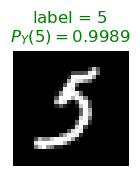

In [11]:
nTest   = len(oTestSet)
idx     = np.random.randint(nTest)
# idx     = 8496
idx     = 3102

mXi, yi = oTestSet[idx]

with torch.no_grad():
    vLogits = oModel(mXi[None,...].to(DEVICE))[0].cpu()

vP = torch.softmax(vLogits, dim=0)
pi = vP[yi]

fig, ax = plt.subplots(figsize=(1.5, 1.5))
ax.matshow          (mXi[0], cmap='gray')
ax.set_title        (f'label = ${yi}$\n' f'$P_Y({yi}) = {pi:5.4f}$', color='g')
ax.axis             ('off')
ax.xaxis.tick_bottom()
plt.show            ()

### Adversarial attack: 

<IPython.core.display.Javascript object>


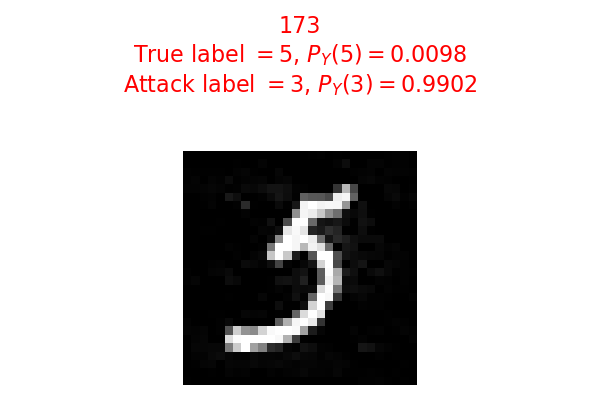

In [12]:
%matplotlib notebook

mXi, yi    = oTestSet[idx]
mOriginalX = mXi.clone()
mXi        = mXi.to(DEVICE)
yAttack    = 3

#-- No need to compute gradients of the model:
for param in oModel.parameters():
    param.requires_grad = False

lr      = 1e-1
fig, ax = plt.subplots(figsize=(6, 4))
for epoch in range(200):
    #-- We want to update mXi using gradient ascent:
    mXi.requires_grad = True
    
    #-- Model output:
    vLogits = oModel(mXi[None])[0]
    vP      = torch.softmax(vLogits, dim=0)
    pTrue   = vP[yi]
    pAttack = vP[yAttack]
    
    #-- Compute the gradient w.r.t mXi
    loss = pAttack
    loss.backward()
    
    # -- Add the gradient:
    with torch.no_grad():
        mXi = mXi + lr * mXi.grad
        #-- Clamp the image:
        mXi = torch.clamp(mXi, -1, 1)
    
    #-- Plot progress:
    color = 'g' if pTrue > pAttack else 'r'
    ax.cla          ()
    ax.matshow      (mXi[0].cpu(), cmap='gray')
    ax.set_title    (f'{epoch}\n'
                     f'True label $   = {yi}$, $    P_Y ({yi})      = {pTrue  :5.4f}$\n'
                     f'Attack label $ = {yAttack}$, $P_Y({yAttack}) = {pAttack:5.4f}$\n',
                     fontsize=16, color=color)
    ax.axis         (False)
    fig.canvas.draw ()
    plt.tight_layout()
    plt.pause       (1e-6)    
        
    if pAttack > 0.99:
        break
        

#### Plot the perturbation:

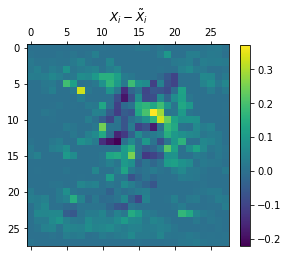

In [13]:
#%matplotlib inline

mDiff = mXi.cpu() - mOriginalX
plt.matshow (mDiff[0])
plt.title   (r'$X_i - \tilde{X}_i$')
plt.colorbar(fraction=0.045);